In [1]:
import numpy as np
import matplotlib.pyplot as plt
import bemcs

np.random.seed(40)

### Create a planar mesh and visualize nodes and patch centers

The patches can be non-uniform in length as long as they are all co-planar. Dealing with rough faults is the next step.

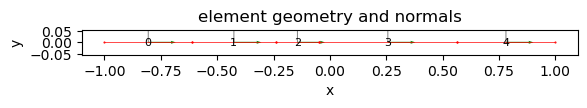

In [2]:
# define a mesh
n_elements = 5

# Elastic parameters
mu_shear = np.array([1])
nu = np.array([0.25])

# for a uniform discretization
# x1, y1, x2, y2 = bemcs.discretized_line(-L, 0, L, 0, n_elements)

# use a non-uniform mesh
# x1 = np.array((-1,-0.5,0.,0.3,0.5,0.9))
# x2 = np.array((-0.5,0.,0.3,0.5,0.9,1.))
sorted_xlocs = np.sort(np.random.uniform(size=n_elements - 1, low=-0.7, high=0.9))
x1 = np.concatenate((np.array([-1.0]), sorted_xlocs))
x2 = np.concatenate((sorted_xlocs, np.array([1.0])))
y1 = np.zeros_like(x1)
y2 = np.zeros_like(x2)

# imposed slip at patch centers (make sure it is the same dimensions as x1)
slip_vector_x = np.random.uniform(size=n_elements)
# slip_vector_x = np.array((1.0, 1.0, 1.0))
# slip_vector_y = np.zeros_like(slip_vector_x)
slip_vector_y = np.random.randn(n_elements)
# slip_vector = np.array((0.1,1.0,2.1,2.1,0.9,0.01))

els = bemcs.initialize_els()
els.x1 = x1
els.y1 = y1
els.x2 = x2
els.y2 = y2
bemcs.standardize_els_geometry(els)
n_els = len(els.x1)
bemcs.plot_els_geometry(els)

### Provide coordinates of observation points
Currently we are only looking at points very close to the fault. The reason it's not exactly on the fault is because I am a bit confused about the coincident and far field calculations. The function values in bemcs.py don't look identical, and so I will leave that for you (Brendan) to explain/fix when you are back.

In [17]:
# observation coordinates for displacement,slip and stress
n_obs = 400
x_obs = np.linspace(-1.5, 1.5, n_obs)
y_obs = 1e-16 * np.ones_like(x_obs)

""" boundary conditions to solve for 3xNpatch unknown 3qn coefficients are as follows:
    (1) Npatch slip values at patch centers
    (2) Npatch-1 internal slip continuity at overlapping nodes
    (3) Npatch-1 internal slip gradient continuity at overlapping nodes
    (4) 2 slip gradients at the boundaries
"""

# Design matrices (in x, y coordinates) for slip and slip gradients at each 3qn
stride = 6
slip_mat, slip_gradient_mat = bemcs.get_matrices_slip_slip_gradient(els, flag="node")
design_mat = np.zeros((n_els * stride, n_els * stride))

# Set boundary conditions
# Slip -or- slip gradients at the boundaries (we set them to 0 here)
bc_vec = np.zeros((n_els * stride))
bc_vec[0:2] = 0.0
bc_vec[-2:] = 0.0
bc_vec[2::stride] = slip_vector_x
bc_vec[3::stride] = slip_vector_y

# Populate design matrix
# Boundary nodes
design_mat[0:2, :] = slip_mat[0:2]
design_mat[-2:, :] = slip_mat[-2:, :]

# Patch center nodes
design_mat[2::stride, :] = slip_mat[2::stride, :]
design_mat[3::stride, :] = slip_mat[3::stride, :]

# Overlapping interior nodes (apply slip continuity and smoothness)
# Slip continuity (x component)
design_mat[4:-7:stride, :] = slip_mat[4:-7:stride, :] - slip_mat[6:-5:stride, :]

# Slip continuity (x component)
design_mat[5:-6:stride, :] = slip_mat[5:-6:stride, :] - slip_mat[7:-4:stride, :]

# Smoothness
# x component
design_mat[6:-5:stride, :] = (
    slip_gradient_mat[4:-7:stride, :] - slip_gradient_mat[6:-5:stride, :]
)
# y component
design_mat[7:-4:stride, :] = (
    slip_gradient_mat[5:-6:stride, :] - slip_gradient_mat[7:-4:stride, :]
)

# Solve for quadratic node coefficients (in local (s, n) coordinates)
coeffs = np.linalg.inv(design_mat) @ bc_vec

# Extract (s, n) components and store them in two separate vectors
coeffs_s = np.zeros((3 * n_els))
coeffs_n = np.zeros((3 * n_els))
for i in range(n_els):
    coeffs_s[3 * i : 3 * (i + 1)] = coeffs[stride * i : stride * i + 3]
    coeffs_n[3 * i : 3 * (i + 1)] = coeffs[stride * i + 3 : stride * (i + 1)]

### Compute fault slip and stress change as a function of x along the fault from 3qn coefficients

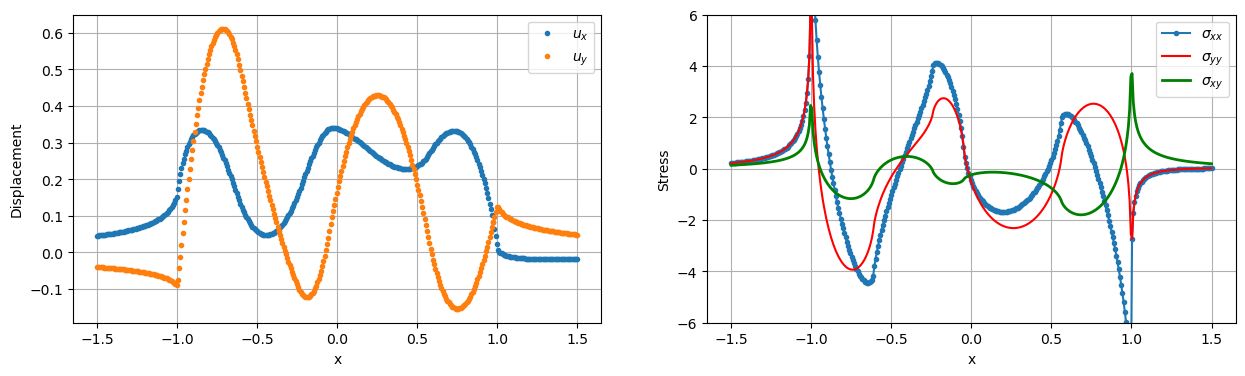

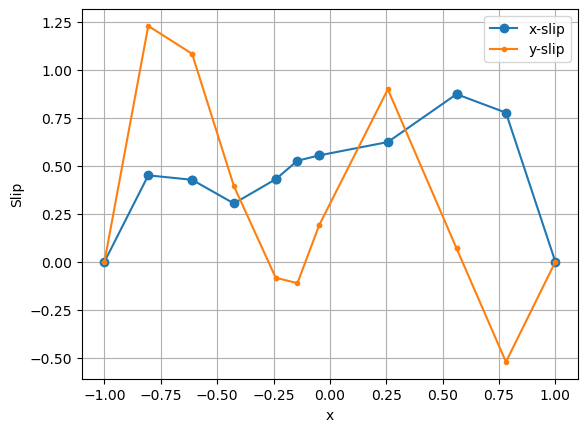

In [18]:
# Compute shear and normal kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu_shear, nu, "shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu_shear, nu, "normal"
)
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)

plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(x_obs, ux, ".", label="$u_x$")
plt.plot(x_obs, uy, ".", label="$u_y$")
plt.grid()
plt.xlabel("x")
plt.ylabel("Displacement")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(x_obs, sxx, ".-", label="$\sigma_{xx}$")
plt.plot(x_obs, syy, "r-", label="$\sigma_{yy}$")
plt.plot(x_obs, sxy, "g-", label="$\sigma_{xy}$", linewidth=2)
plt.legend()
plt.grid()
plt.xlabel("x")
plt.ylabel("Stress")
plt.ylim(-6, 6)
plt.show()

x_nodes = np.zeros((3 * n_els, 1))
x_nodes[0::3, 0] = els.x1
x_nodes[2::3, 0] = els.x2
x_nodes[1::3, 0] = els.x_centers
fault_slip = slip_mat @ coeffs
fault_slip_x = fault_slip[0::2]
fault_slip_y = fault_slip[1::2]
plt.figure()
plt.plot(x_nodes, fault_slip_x, "o-", label="x-slip")
plt.plot(x_nodes, fault_slip_y, ".-", label="y-slip")
plt.grid()
plt.legend()
plt.xlabel("x")
plt.ylabel("Slip")
plt.show()

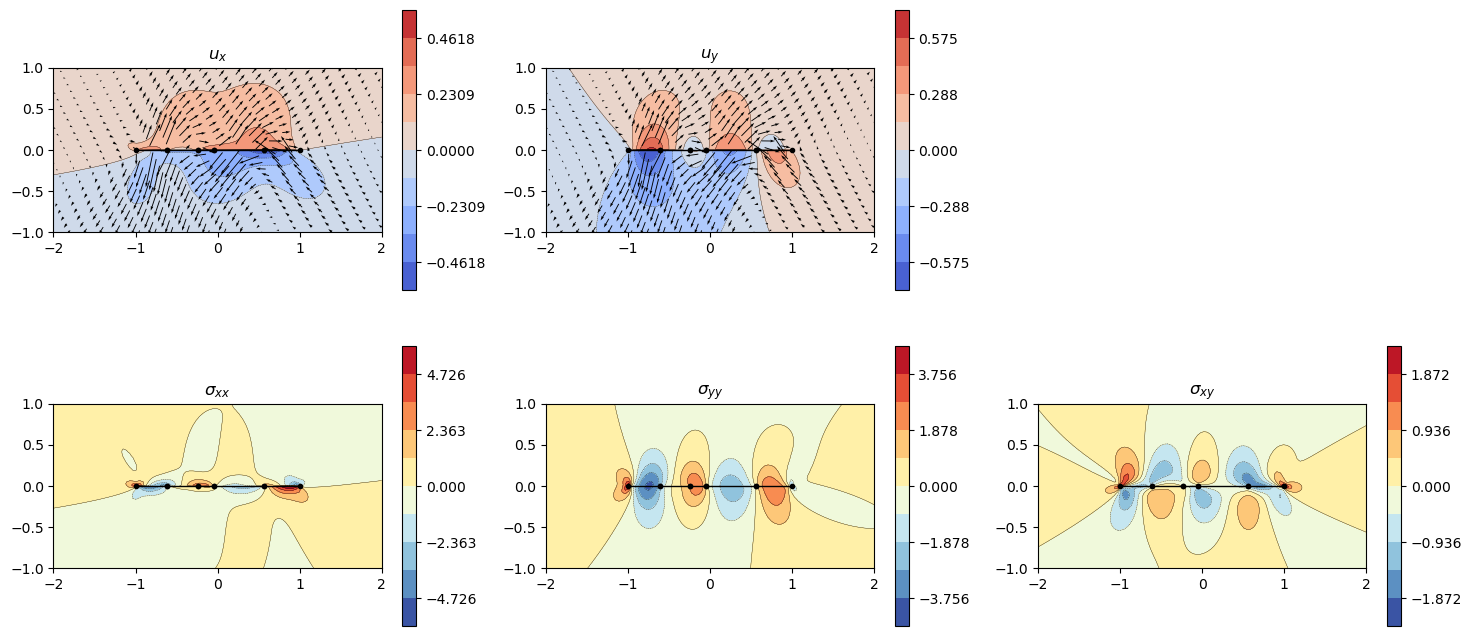

In [5]:
# plot bulk stresses
n_obs = 100
width = 2
x_obs = np.linspace(-width, width, n_obs)
y_obs = np.linspace(-width / 2, width / 2, n_obs)

x_obs, y_obs = np.meshgrid(x_obs, y_obs)
x_obs = x_obs.flatten()
y_obs = y_obs.flatten()

# Compute shear and normal kernels
kernels_s = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu_shear, nu, "shear"
)
kernels_n = bemcs.get_displacement_stress_kernel(
    x_obs, y_obs, els, mu_shear, nu, "normal"
)
ux, uy, sxx, syy, sxy = bemcs.coeffs_to_disp_stress(
    kernels_s, kernels_n, coeffs_s, coeffs_n
)

n_skip_plot = 21  # plotting for vectors
bemcs.plot_displacements_stresses_els(
    els, n_obs, ux, uy, sxx, syy, sxy, x_obs, y_obs, n_skip_plot
)